In [1]:
import numpy as np
import pylab
import math
import matplotlib.pyplot as plt
import copy
import queue
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
plt.rc('font', family='Verdana')
%matplotlib inline

In [2]:
#функция удаления нулей и обработки скачков
#data - массив данных
#k - коэффициент отбора скачков
def transform(data, k): 
    data2 = copy.deepcopy(data)
    
    
    
    #массив индексов по каждой точке потребления, отсюда удаляются индексы с нулевым значением потребления
    index_n = [[i for i in range(len(data[i][3]))] for i in range(len(data))]
    #массив индексов по каждой точке потребления для графика
    index = [[i for i in range(len(data[i][3]))] for i in range(len(data))]
    
    
    for i in range(len(data)):
        num = []
        
        #Удаляем нули из данных, считаем их отсуствием данных, а не скачком
        for j in range(len(data2[i][3])):
            if data2[i][3][j] != 0:
                num.append(data2[i][3][j])
                index_n[i].remove(j)
                
        data2[i][3] = num
        
        #первое значение потребления для i строки
        num = [data2[i][3][0]]
        #значение индекса 0 
        numi = [0]
        #
        s = 0
        
        #Проходим по всем месяцам потребления для точки i
        for j in range(len(data2[i][3])-1):
            
            #Если текущее значение/следующее значение < k и текущее значение/следующее значение > 1/k
            if data2[i][3][j]/data2[i][3][j+1] < k and data2[i][3][j]/data2[i][3][j+1] > 1/k:
                #Если скачков нет и до этого скачка не было, то добавлением значение в num
                if s == 0:
                    num.append(data2[i][3][j+1])
                    numi.append(j+1)
                #Если скачок был и это его продолжение, то записываем в num и увеличиваем s
                elif s > 0 and s < 6:
                    num.append(data2[i][3][j+1])
                    numi.append(j+1)
                    s += 1
                #Если продолжение скачка больше 6, то принимаем значения посе скачка, как правильные, значени до этого отсекаем
                else:
                    num = num[-6:]
                    numi = numi[-6:]
                    s = 0
            #Если произошёл скачок
            else:
                #Если произошёл скачок 
                if s == 0:
                    num.append(data2[i][3][j+1])
                    numi.append(j+1)
                    s = 1
                #Если произошёл скачок внутри скачка
                else:
                    #Если второй скачок произошёл на конце отрезка данных значений
                    if j-s > len(data2[i][3]) - 5:
                        num = num[:-s]
                        numi = numi[:-s]
                        break
                    #Если произошёл второй скачок и он возвращает данные назад к значениям до первого скачка
                    elif data2[i][3][j-s]/data2[i][3][j+1] < k and data2[i][3][j-s]/data2[i][3][j+1] > 1/k:
                        #убираем значения в этом скачке и добавляем новое
                        num = num[:-s]
                        numi = numi[:-s]
                        num.append(data2[i][3][j+1])
                        numi.append(j+1)
                        s = 0
                    #Если второй скачок произошёл и он усугубил ситуацию, то удаляем значения до первого скачка и 
                    #говорим, что второй скачок - это первый
                    else:
                        num = num[:-s]
                        numi = numi[:-s]
                        num.append(data2[i][3][j+1])
                        numi.append(j+1)
                        s = 1
        #Обработка конца значения, если один скачок произошёл в конце, то его значения отсекаем
        if s <= 3 and len(num) > 5:
            data2[i][3] = num[:-s]
            index[i] = numi[:-s]
        #Если значений без скачков меньше 5, то ошибка - не можем предсказывать
        if s <= 3 and len(num) - s <= 5:
            data2[i][3] = 'error'
            index[i] = 'error'
        #Если всё хорошо,то добавляем значения в основной массив точек
        else: 
            data2[i][3] = num
            index[i] = numi
        if index[i] != 'error':
            for j in index_n[i]:
                for k in range(len(index[i])):
                    if index[i][k] >= j:
                        index[i][k] += 1
    return data2, index

def classification(data): #классификация по типу и региону
    d = dict()
    for lst in data:
        l = (lst[1],lst[2])
        if lst[3] != 'error':
            if l in d:
                d[l].append(lst[0])
            else:
                d[l] = [lst[0]]
    return d

def distance(a,b): 
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def clustering(x, y, k):
    q = queue.PriorityQueue()
    sets = [set([i]) for i in range(len(x))]
    sets_c = []
    nb_sets = len(x)
    for i, aa in enumerate(x):
        for j in range(i+1, len(x)):
            q.put((distance( (x[i],y[i]), (x[j], y[j])), (i,j) ))
    dis = 0
    while not q.empty() and nb_sets >= k:
        e = q.get()
        u = e[1][0]
        v = e[1][1]
        dis = e[0]
        set_uv = [s for s in sets if u in s or v in s]

        if len(set_uv) > 1 and set_uv[0].isdisjoint(set_uv[1]):
            unionset = set_uv[0].union(set_uv[1])
            sets_c = copy.copy(sets)
            sets.remove(set_uv[0])
            sets.remove(set_uv[1])
            sets.append(unionset)
            nb_sets -= 1
    return sets_c

def f(x, a, b, c, d): #аппроксимирующая функция
    return a*np.sin(b*x)+c*x+d

def linear(x, y): #линейная аппроксимирующая функция
    n = len(x)
    x = np.array(x)
    y = np.array(y)
    a = (n*np.sum(x*y)-np.sum(x)*np.sum(y))/(n*np.sum(x**2)-(np.sum(x))**2)
    b = (np.sum(y)-a*np.sum(x))/n
    return a, b

def f2(x, a, b): #линейная аппроксимирующая функция
    x = np.array(x)
    return a*x+b

def prediction (id, month): #функция предсказания 
    #clust_vect - словарь с ключом (тип, регион), содержащий все кластеры этого класса
    for i in clust_vect:
        for j in range(len(clust_vect[i])):
            for k in range(len(clust_vect[i][j])):
                if clust_vect[i][j][k] == id:
                    #voc - словарь id-номер строки 
                    v = voc[id]
                    #clust_sim - словарь, 
                    #print(clust_sim[i][j][1])
                    return data2[v][3][0] + (month - index[v][0]) * clust_sim[i][j][1]

def draw_prediction(id, months): #функция построения графика предсказаний
    i = voc[id]
    if index[i] != 'error':
        try:
            a, b = curve_fit(f, index[i], data2[i][3])
            plt.scatter(index[i], data2[i][3], color = 'r')
            plt.plot(np.array(index[i]), f(np.array(index[i]), a[0], a[1], a[2], a[3]))
            plt.ylim = [min(data2[i][3]), max(data2[i][3])]
        except Exception:
            a, b = linear(index[i], data2[i][3])
            plt.scatter(index[i], data2[i][3], color = 'r')
            plt.plot(index[i], f4(index[i], a, b))
            plt.ylim = [min(data2[i][3]), max(data2[i][3])]
        for j in months:
            plt.scatter(j, prediction (id, j)) 
    else:
        print('Невозможно предсказать модель')

In [3]:
#считываение данных
fin = open(r'Данные.csv', 'r')
#Массив точек  информацией по точке (id, тип, регион, показания за 28 периодов)
data = []
exp = []

cnt = 'inf'

for item in fin.readlines():
    #Первую строку не считываем
    if cnt == 'inf':
        cnt = 0
    else:
        data.append([])
        num = []
        lst = list(item.split(';'))
        #Добавляем id
        data[cnt].append(int(lst[0]))
        #Добавляем тип
        data[cnt].append(lst[1].replace(" ", ""))
        #Добавляем регион
        data[cnt].append(lst[2])
        #Добавляем массив значений энергопотребления
        for i in lst[3:]:
            i = i.replace(",", ".")
            i = i.replace(" ", "")
            if i == '' or i == '\n':
                num.append(0)
            else:
                num.append(float(i))
        data[cnt].append(num)
        cnt += 1
fin.close()

In [4]:
#транформация матриц, T - коэффициент отбора скачков
T = 2
data2, index = transform(data, T)

In [5]:
#словарь id - номер строки
voc = {}
for i in range(len(data2)):
    voc[data2[i][0]] = i

In [6]:
#Словарь индекс - (среднее, коэффициент тенденции), в случае зацикливания аппорксимирующей функции f, используется
#линейная регрессия
d = {}
error = []
s = 0
s1 = 0
for i in range(len(data2)):
    if index[i] != 'error':
        try:
            a, b = curve_fit(f, index[i].astype(np.float64), data2[i][3])
            d[data2[i][0]] = (np.mean(np.array(data2[i][3])), a[2])
        except:
            a, b = linear(index[i], data2[i][3])
            d[data2[i][0]] = (np.mean(np.array(data2[i][3])), a)
    else:
        error.append(data2[i][0])

In [7]:
#Словарь (тип, регион) - индексы 
clas = classification(data2)
print(clas)

{('WPUMP', 'pafos'): [4610728, 5240158, 6403724, 21440403, 23141961, 28240787, 29340678, 91540017, 112050316, 126430489, 128240693, 146948096, 159340373, 174340269], ('WPUMP', 'nicosia'): [4820874, 5430888, 5514455, 7630426, 11740840, 23210210, 28800007, 31430708, 33620131, 33820836, 39800928, 40720190, 41802476, 43325068, 46220465, 47010032, 49420716, 53050736, 61330384, 66430672, 69449015, 73095676, 78530999, 78800869, 83150993, 84607084, 89897558, 91050320, 96240145, 99720698, 107920744, 113100655, 122820208, 123820241, 128620631, 132230468, 134333886, 134510286, 134630468, 147530873, 147900821, 157410076, 158530190, 168900634, 171740179], ('WPUMP', 'lemesos'): [6350266, 11707816, 12638490, 15140613, 26546876, 68520425, 76640946, 84150738, 90130403, 90130717, 91550413, 101940361, 109400892, 115500547, 123540410, 123838204, 136730469, 138940519, 156550950, 159200836], ('WPUMP', 'famagusta'): [8449914, 31781683, 32300070, 64420322, 64585799, 68779007, 89320815, 109500945, 129810824], 

In [8]:
# Словарь индекс - (тип, регион) - нормированные (среднее, коэффициент тенденции) 
d_norm = {}
for i in clas:
    ar_mean = []
    ar_koef = []
    for j in clas[i]:
        if j not in error:
            ar_mean.append(d[j][0])
            ar_koef.append(d[j][1])
        else:
            clas[i].remove(j)
    ar_mean = np.array(ar_mean)
    ar_koef = np.array(ar_koef)
    for j in clas[i]:
        if j not in error:
            d_norm[j] = ((d[j][0] - np.min(ar_mean))/(np.max(ar_mean)-np.min(ar_mean)), 
            (d[j][1] - np.min(ar_koef))/(np.max(ar_koef)-np.min(ar_koef)))
            #kf = (np.max(ar_mean)-np.min(ar_mean))/(np.max(ar_koef)-np.min(ar_koef))
            #d_norm[j] = (d[j][0]/kf, d[j][1])
print(d_norm)

{4610728: (0.05171348351652896, 0.009047147930444806), 5240158: (0.05228590214483971, 0.01821881105877245), 6403724: (0.32299037188798857, 0.3030635054755944), 21440403: (0.3710754821293396, 0.0), 23141961: (0.0, 0.005396900413270449), 28240787: (0.4689371245547698, 1.0), 29340678: (0.01585456919405794, 0.0017927391484486635), 91540017: (0.0069407767739699784, 0.0021593655164611433), 112050316: (0.3203674349959804, 0.20350181392168162), 126430489: (0.03854711377079881, 0.03384794905216182), 128240693: (0.8850271939258969, 0.7506021107930155), 146948096: (0.10180196847030487, 0.00524986841391099), 159340373: (0.0404235983400526, 0.011290205792228067), 174340269: (1.0, 0.23853965277379424), 4820874: (0.0, 0.002431313217259364), 5430888: (0.08249557975607649, 0.007477463677774378), 5514455: (0.27724286810375337, 0.10742248011367704), 7630426: (0.7845815498910427, 1.0), 11740840: (0.4458845350692866, 0.21257613245413237), 23210210: (0.026968935179689478, 0.0064962170289289516), 28800007: (

('WPUMP', 'pafos') [[28240787], [128240693], [174340269], [4610728, 5240158, 23141961, 29340678, 91540017, 126430489, 146948096, 159340373], [112050316, 6403724, 21440403]]
('WPUMP', 'nicosia') [[47010032], [147530873], [33620131, 61330384, 132230468], [4820874, 5430888, 5514455, 11740840, 23210210, 28800007, 31430708, 33820836, 39800928, 40720190, 41802476, 43325068, 46220465, 49420716, 53050736, 66430672, 73095676, 78530999, 78800869, 83150993, 84607084, 89897558, 91050320, 96240145, 99720698, 107920744, 113100655, 122820208, 123820241, 128620631, 134333886, 134510286, 134630468, 147900821, 157410076, 158530190, 168900634, 171740179], [7630426, 69449015]]
('WPUMP', 'lemesos') [[11707816], [15140613], [136730469], [90130403, 90130717], [6350266, 12638490, 26546876, 68520425, 76640946, 84150738, 91550413, 101940361, 109400892, 115500547, 123540410, 123838204, 138940519, 156550950, 159200836]]
('WPUMP', 'famagusta') [[8449914], [31781683], [32300070], [129810824], [64420322, 64585799, 6

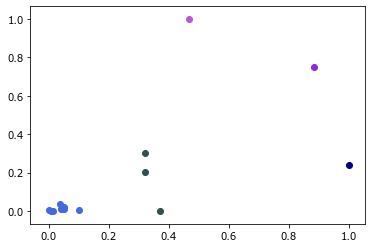

In [9]:
#Словарь (тип, регион) - разбивка на кластеры, nc - количество кластеров в каждой группе 
clust_vect = {}
nc2 = 3
pp = 0
num_of_clust = 0
clr = ['mediumorchid', 'blueviolet', 'navy', 'royalblue', 'darkslategrey', 
       'limegreen', 'darkgreen', 'yellow', 'darkorange', 'y']
for i in clas:
    if i[0] == 'WPUMP':
        nc1 = 5 #len(clas[i])//5 + 1
        ar_mean = []
        ar_koef = []
        for j in clas[i]:
            ar_mean.append(d_norm[j][0])
            ar_koef.append(d_norm[j][1])
        ar_mean = np.array(ar_mean)
        ar_koef = np.array(ar_koef)
        cl = clustering(ar_mean, ar_koef, nc1)
        ck = []
        for j in range(len(cl)):
            ck.append([])
            for k in cl[j]:
                ck[j].append(clas[i][k])
                if pp == num_of_clust:
                    plt.scatter(d_norm[clas[i][k]][0], d_norm[clas[i][k]][1], c = clr[j])
        clust_vect[i] = ck
    else:
        ar_mean = []
        ar_koef = []
        for j in clas[i]:
            ar_mean.append(d_norm[j][0])
            ar_koef.append(d_norm[j][1])
        ar_mean = np.array(ar_mean)
        ar_koef = np.array(ar_koef)
        cl = clustering(ar_mean, ar_koef, nc2)
        ck = []
        for j in range(len(cl)):
            ck.append([])
            for k in cl[j]:
                ck[j].append(clas[i][k])
        clust_vect[i] = ck
    pp += 1
ccnt = 0
for i in clust_vect:
    print(i, clust_vect[i])
    ccnt+=len(clust_vect[i])
print(ccnt)

In [10]:
for i in range(len(data2)):
    if data2[i][0] == 90130403 or data2[i][0] == 90130717:
        print (data2[i][0], data2[i][3])

90130403 [32010.0, 40066.0, 40066.0, 40066.0, 40066.0, 89766.0, 112155.0, 112158.0, 122156.0, 137192.0, 152545.0, 165241.0, 172500.0, 179081.0, 189278.0, 204278.0, 208990.0, 218845.0, 224643.0, 231162.0, 237162.0, 246162.0, 265665.0, 271961.0, 280993.0, 288993.0, 299617.0]
90130717 [32010.0, 40066.0, 40066.0, 40066.0, 40066.0, 89766.0, 112155.0, 112158.0, 122156.0, 137192.0, 152545.0, 165241.0, 172500.0, 179081.0, 189278.0, 204278.0, 208990.0, 218845.0, 224643.0, 231162.0, 237162.0, 246162.0, 265665.0, 271961.0, 280993.0, 288993.0, 299617.0]


In [11]:
#Словарь (тип, регион) - (среднее, коэффицент в каждом кластере), рассчитывается, как среднее по кластеру
clust_sim ={}
for i in clust_vect:
    l = []
    for j in clust_vect[i]:
        ar_mean = []
        ar_koef = []
        for k in j:
            ar_mean.append(d[k][0])
            ar_koef.append(d[k][1])
        ar_mean = np.mean(np.array(ar_mean))
        ar_koef = np.mean(np.array(ar_koef))
        l.append((ar_mean, ar_koef))
    clust_sim[i] = l
print(clust_sim)

{('WPUMP', 'pafos'): [(385766.9259259259, 25324.007936507936), (726386.0370370371, 19009.452991452992), (820504.925925926, 6044.441391941392), (33358.781614219115, 280.1640534117524), (278697.58024691354, 4280.084452584452)], ('WPUMP', 'nicosia'): [(547458.7037037037, 8149.507936507936), (63420.5625, 7615.823839009288), (738346.8225308642, 1727.3513898705417), (129120.71436159844, 1480.9665578571037), (550132.1666666666, 20233.094322344325)], ('WPUMP', 'lemesos'): [(594518.0, 8517.272893772893), (750169.7777777778, 6330.736263736264), (247718.7037037037, 133.44078144078145), (170474.7037037037, 10628.222222222223), (46454.10370370371, 437.6436304436304)], ('WPUMP', 'famagusta'): [(474537.6296296296, 11479.362637362638), (653507.6296296297, 6003.53601953602), (423398.22222222225, 2942.8559218559217), (143184.96296296295, 4528.059218559219), (87381.90992592592, 1407.5554065934066)], ('WPUMP', 'larnaka'): [(122651.66666666667, 1373.41452991453), (165015.42857142858, 22698.476312419974), (

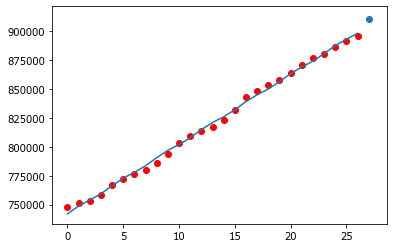

In [12]:
id = 174340269
month = [27]
draw_prediction(id, month)

In [23]:
for i in clust_vect:
    for j in clust_vect[i]:
        sum_cluster = 0
        for m in range(len(j)):
            sum_cluster += prediction(j[m], 27)
            #print(j[m])
        print (i, j, sum_cluster)

('WPUMP', 'pafos') [28240787] 696813.2142857143
('WPUMP', 'pafos') [128240693] 1004072.2307692308
('WPUMP', 'pafos') [174340269] 910786.9175824176
('WPUMP', 'pafos') [4610728, 5240158, 23141961, 29340678, 91540017, 126430489, 146948096, 159340373] 298242.7793232915
('WPUMP', 'pafos') [112050316, 6403724, 21440403] 1027441.8406593406
('WPUMP', 'nicosia') [47010032] 660931.7142857143
('WPUMP', 'nicosia') [147530873] 133185.0052631579
('WPUMP', 'nicosia') [33620131, 61330384, 132230468] 2305315.462579514
('WPUMP', 'nicosia') [4820874, 5430888, 5514455, 11740840, 23210210, 28800007, 31430708, 33820836, 39800928, 40720190, 41802476, 43325068, 46220465, 49420716, 53050736, 66430672, 73095676, 78530999, 78800869, 83150993, 84607084, 89897558, 91050320, 96240145, 99720698, 107920744, 113100655, 122820208, 123820241, 128620631, 134333886, 134510286, 134630468, 147900821, 157410076, 158530190, 168900634, 171740179] 5679760.059489245
('WPUMP', 'nicosia') [7630426, 69449015] 1730911.0934065934
('W